<a href="https://colab.research.google.com/github/Kaivan-Khazeni/WaterQualityModel/blob/main/Water_Quality_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kaivan Khazeni**

April 26th, 2022

Dataset : Water Potability (via Kaggle)

Goal: Determine if water is drinkable given other metrics. 0 and 1 indicate drinkable vs. not drinkable



The goal of this module is to implement two models and compare accuracy, time usage, and memory usage.

The data set as a target domain of {0,1} meaning a binary classification. 

Models of choice:


1.   KNN - K Nearest Neighbors Classification Model
2.   Naive Bayes Classifcation Model
3.   Logistic Regression
4.   RandomForest
5.   XGBoost

Proper data processing will be done prior to model implementation.



#Packages and Imports

In [163]:
import pandas as pd
import io
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns


import numpy as np
import statsmodels.formula.api as smf
import seaborn as sb


import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Modelling Libraries
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier,PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.ensemble import VotingClassifier

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold

# Data Retrieval and Processing

The data was found via Kaggle, however in order for others to run this colab file, I uploaded to Google spreadsheet and now am reading that public spreadsheet. Please click on ss_link to view original file:

In [3]:
ss_link = "https://docs.google.com/spreadsheets/d/1h5L6sYQb5aw_rLSQaRamdKH94wtLkeDxGaQeTn4Cp6A/edit#gid=1338418011"
new_link = "https://docs.google.com/spreadsheets/d/1h5L6sYQb5aw_rLSQaRamdKH94wtLkeDxGaQeTn4Cp6A/export?format=csv&gid=1338418011"

In [142]:
df = pd.read_csv(new_link)
df.head(5)

ph    Hardness       Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890456  20791.31898     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.05786     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.54173     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.41744     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.98634     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436525       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

Right away, we see NaN values, meaning an entry/row had missing data for that individual report of sample.

The columns are all float types, except for the target variable , 'Potability'

In [111]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

ph: pH of 1. water (0 to 14).

Hardness: Capacity of water to precipitate soap in mg/L.

Solids: Total dissolved solids in ppm.

Chloramines: Amount of Chloramines in ppm.

Sulfate: Amount of Sulfates dissolved in mg/L.

Conductivity: Electrical conductivity of water in μS/cm.

Organic_carbon: Amount of organic carbon in ppm.

Trihalomethanes: Amount of Trihalomethanes in μg/L.

Turbidity: Measure of light emiting property of water in NTU.

Potability: Indicates if water is safe for human consumption. Potable - 1 and Not potable - 0

In [112]:
df.shape

(3276, 10)

In [113]:
#Check for missing data
print(df.isnull().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In regards to missing data, the approaches vary. Considering the size of the data set (3276 entries), removing a mass amount of 781 entries (in regards to the Sulfate column) could have an adverse effect in our accuracy of our model.

To fill these column values, I will fill with the median of the column values. The reason for median over mean or mode is that if there is noise in the data, such as outliers, we want to avoid those impacting our model as much as possible.

In [143]:
df['ph'].fillna((df['ph'].median()), inplace=True)
df['Sulfate'].fillna((df['Sulfate'].median()), inplace=True)
df['Trihalomethanes'].fillna((df['Trihalomethanes'].median()), inplace=True)

In [115]:
#Check for missing data
print(df.isnull().sum())


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


At this point, all missign data is filled with averages of their respective columns 

In [146]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean      7.074194   196.369496  22014.092526     7.122277   333.608364   
std       1.470040    32.879761   8768.570828     1.583085    36.143851   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.277673   176.850538  15666.690300     6.127421   317.094638   
50%       7.036752   196.967627  20927.833605     7.130299   333.073546   
75%       7.870050   216.667456  27332.762125     8.114887   350.385756   
max      14.000000   323.124000  61227.196010    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3276.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.407478     3.966786     0.390110  
std       80.824064        3.308162        15.769958     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        56.647656     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792305       16.557652        76.666609     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

## Visualizing Distribution of Columns

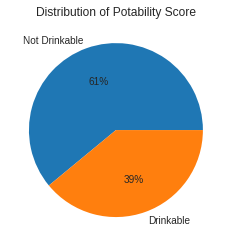

In [138]:
x = [len(df[df['Potability']==0]),len(df[df['Potability']==1])]
labels = ['Not Drinkable', 'Drinkable']

fig, ax = plt.subplots()
ax.pie(x, labels = labels,autopct='%.0f%%')
ax.set_title('Distribution of Potability Score')
plt.show()

We see that the split is roughly 60-40 in favor of 0 (non potable). This is not drastic however if needed, we can oversample the drinkable entries, or remove at random the non-drinkable entries to get a 50-50 split

Next up, we want to visualize the distributions of the other metrics we will be using in our model, or observe normality or lack there of.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


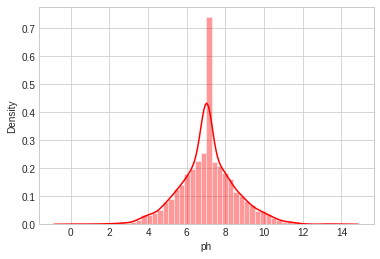

In [144]:
#PH
sns.distplot(a=df['ph'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


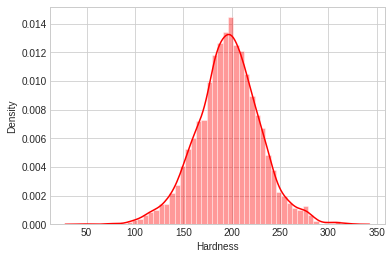

In [147]:
#Hardness
sns.distplot(a=df['Hardness'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


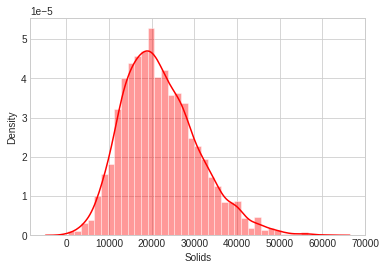

In [150]:
#Solids
sns.distplot(a=df['Solids'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


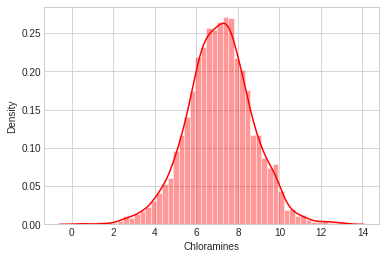

In [149]:
#Chloramines
sns.distplot(a=df['Chloramines'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


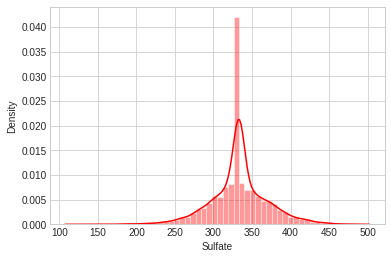

In [157]:
#Sulfate
sns.distplot(a=df['Sulfate'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


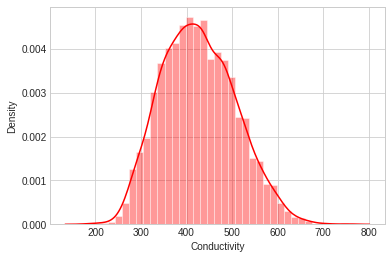

In [156]:
#Conductivity
sns.distplot(a=df['Conductivity'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


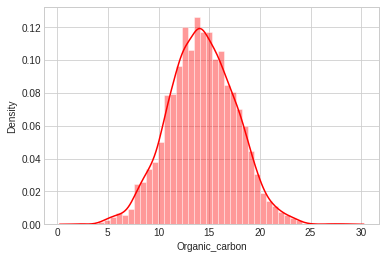

In [152]:
#Organic Carbon
sns.distplot(a=df['Organic_carbon'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


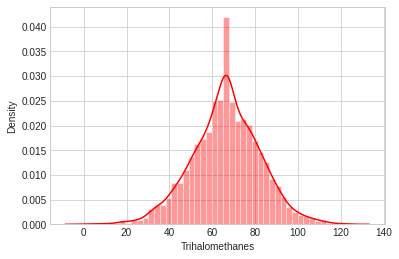

In [155]:
#Trihalomethans
sns.distplot(a=df['Trihalomethanes'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


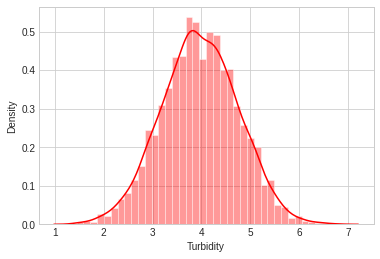

In [153]:
#Turbidity
sns.distplot(a=df['Turbidity'], color='red',
             hist_kws={"edgecolor": 'white'})
 
plt.show()

We do see that all the distrbutions had a normal bell curve, and it is safe to assume this throughout the model testing phase.

If we do notice more medians, we did replace NaN values with median therefore this is an expected trend in the distrbution graphs.

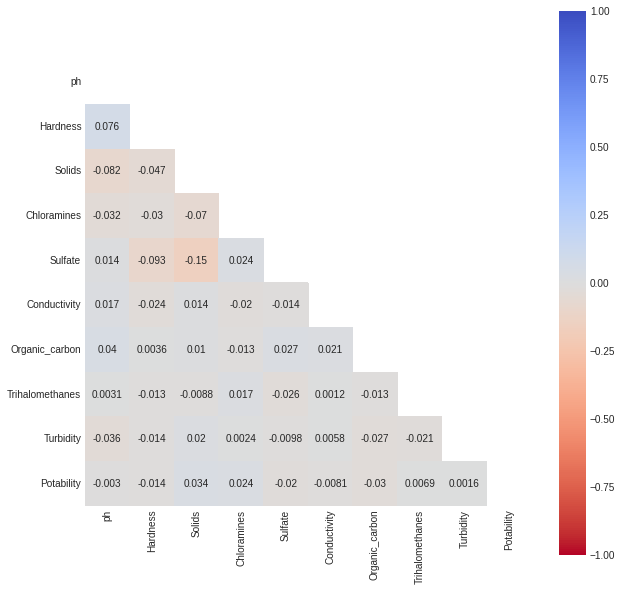

In [160]:
df_corr =  df[df.columns].corr()

df_mask = np.zeros_like(df_corr) #array of zeros of the same shape
df_mask[np.triu_indices_from(df_mask)] = True #turn upper triangle into ones

f,ax = plt.subplots(1,1,figsize=(10,10))

sb.heatmap(df_corr,vmin=-1,vmax=1,mask=df_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')

There also seems to be no true correlation between variables. Usually, if there are relationships, this could help model implementation, however it appears that there is not. 

# Model Experimentation

As stated previously, we are dealing with a classification problem, meaning the predicted values will be placed into a 0 or 1 class (non potable versus potable).



## Splitting Data Into Train and Test Splits

In [ ]:
import random
df = df.sample(frac=1)

In [211]:
#Create X and y dataframes then create a split 
y = df['Potability']
X = df[['ph','Hardness','Solids','Chloramines','Sulfate', 'Conductivity', 'Organic_carbon',
       'Trihalomethanes','Turbidity']]



#Splitting data : Rule of thumb is 30 percent of data is testing data.
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                     test_size = .3,
                                                     random_state = 21)

There are many ways to experiment with testing models. In this situations I will perform a rapid test of the select models, and pick the top 3 to perform hyperparameter tuning on. Since the models with lower accuracy will already be behind, hyperparameter tuning would not change the results of the top ranked performing models.

## Rapid Model Examination

In [212]:
models =[("KNN", KNeighborsClassifier(n_neighbors=3)),
         ("GNB", GaussianNB()),
        ("LogReg", LogisticRegression()),
         ('RF',RandomForestClassifier()),
        ('XGB',GradientBoostingClassifier())]

In [213]:
def rapid_model_standard(models, X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  results = []
  model_type = []
  accuracy = []

  for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = precision_score(y_test, model_results,average='macro')
    results.append(score)
    model_type.append(name)
    accuracy.append((name,score))
    
  accuracy.sort(key=lambda k:k[1],reverse=True)
  print("With Standardization of Train and Test sets")
  for (name,score) in accuracy:
    print(str(name) + ": " + str(score))

In [214]:
def rapid_model_without_scale(models, X_train, X_test, y_train, y_test):
  results = []
  model_type = []
  accuracy = []

  for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = precision_score(y_test, model_results,average='macro')
    results.append(score)
    model_type.append(name)
    accuracy.append((name,score))
    
  accuracy.sort(key=lambda k:k[1],reverse=True)
  print("Without Standardization of Train and Test sets")
  for (name,score) in accuracy:
    print(str(name) + ": " + str(score))
  

In [217]:
rapid_model_standard(models,X_train.copy(),X_test.copy(),y_train.copy(),y_test.copy())
print("\n")
rapid_model_without_scale(models,X_train,X_test,y_train,y_test)

With Standardization of Train and Test sets
RF: 0.6397516512214602
XGB: 0.6375608470529873
LogReg: 0.6353741496598639
KNN: 0.5949087555814405
GNB: 0.5863020710292148


Without Standardization of Train and Test sets
RF: 0.636031371124031
XGB: 0.6331568853087841
GNB: 0.5865602819757616
KNN: 0.5221137517055885
LogReg: 0.3014256619144603


As seen, the results differ based off of Standardizing the datasets. In research, it has been proven, and backed by results above, that StandardScale function from sklearn boosts logistic regression results.

In this case, I will continue with the top 3 from the scaling results


1.   Random Forest
2.   XGBoost
3.   Logistic Regression





## Hyperparameter Tuning and Model Optimization